In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

visualize the raw data

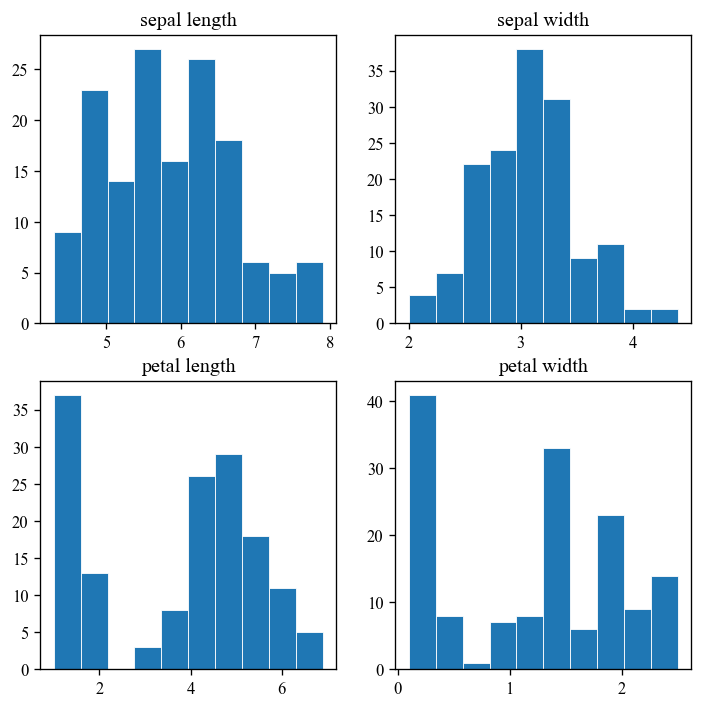

In [2]:
data_path = '.\data\iris.data'
iris_raw_data = pd.read_csv(data_path, 
        names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'], 
        delimiter=',')

mpl.rcParams['font.sans-serif'] = 'Times New Roman'
fig, axs = plt.subplots(2,2, figsize=(7, 7), dpi=120)
bins = [10,10,10,10]
titles = ['sepal length', 'sepal width', 'petal length', 'petal width']
for i in range(2):
    for j in range(2):
        ax = axs[i, j]
        ax.hist(iris_raw_data.iloc[:, i*2+j].values, bins=bins[i*2+j], linewidth=0.5, edgecolor="white")
        ax.set_title(titles[i*2+j])
plt.savefig('viz_raw_data.pdf', format='pdf', bbox_inches='tight', transparent=True, dpi=120)
plt.show()

use Silhouette value to select k value for each attribute

In [25]:
from kmeans import Kmeans1d
km = Kmeans1d()
attrs=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
center_points = []
records = []
all_scores = []
for i, a in enumerate(attrs):
    _, best_cps, best_rcd, all_score = km.auto_fit(iris_raw_data[attrs[i]], max_k=6)
    center_points.append(best_cps)
    records.append(best_rcd)
    all_scores.append(all_score)

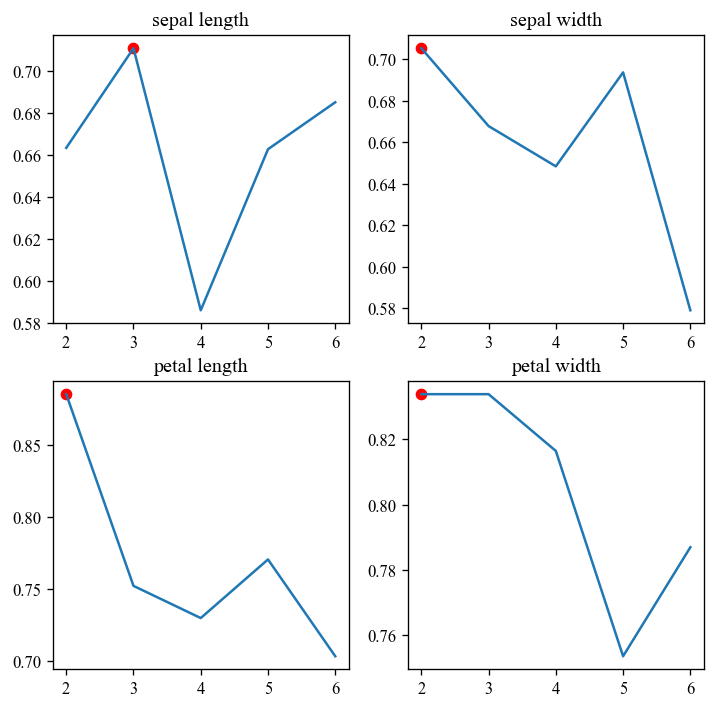

In [26]:
fig, axs = plt.subplots(2,2, figsize=(7, 7), dpi=120)
titles = ['sepal length', 'sepal width', 'petal length', 'petal width']
for i in range(2):
    for j in range(2):
        ax = axs[i, j]
        idx = i*2+j
        scores = all_scores[idx]
        kk = np.arange(len(scores))+2
        ax.plot(np.argmax(scores)+2,np.max(scores),'ro')
        ax.plot(kk, scores)
         
        ax.set_title(titles[idx])
plt.savefig('Silhouette_scores.pdf', format='pdf', bbox_inches='tight', transparent=True, dpi=120)
plt.show()

In [45]:
from copy import deepcopy
all_records = []
temp_records = deepcopy(records)
for i, rcd in enumerate(temp_records):
    attr = attrs[i]
    attr = [attr]*rcd.shape[0]
    rcd.insert(len(rcd.columns), 'attribute', attr)
    all_records.append(rcd)
all_records = pd.concat(all_records)
all_records

,data,cluster,attribute
0,5.1,0.0,sepal_length
1,4.9,0.0,sepal_length
2,4.7,0.0,sepal_length
3,4.6,0.0,sepal_length
4,5.0,0.0,sepal_length
...,...,...,...
145,2.3,1.0,petal_width
146,1.9,1.0,petal_width
147,2.0,1.0,petal_width
148,2.3,1.0,petal_width


The result of k means

d:\software\anaconda\anacondasoftware\envs\torchCPU\lib\site-packages\seaborn\categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)
d:\software\anaconda\anacondasoftware\envs\torchCPU\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


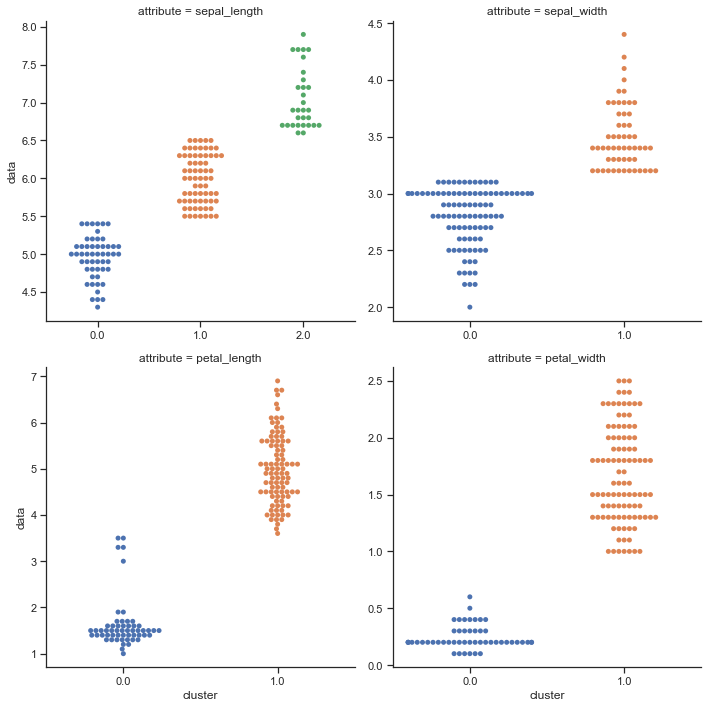

In [48]:
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)
swarm_plot = sns.catplot(x="cluster", y="data", col="attribute", col_wrap=2, kind="swarm", data=all_records, sharex=False, sharey=False)
fig = swarm_plot.fig
fig.savefig('swarm_plot.pdf', format='pdf', bbox_inches='tight', transparent=True, dpi=120)

Whole precoess:

* Attribute selection
* Tree growth
* Tree pruning
* Predict

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from copy import deepcopy
from decision_tree import Node, DecisionTree
from sklearn import metrics

if __name__ == '__main__':
    
    data_path = '.\data\iris.data'
    iris_raw_data = pd.read_csv(data_path, 
            names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'], 
            delimiter=',')

    train_mask = np.random.rand(len(iris_raw_data)) < 0.8
    temp_train_iris_data = iris_raw_data[train_mask]
    test_iris_data = iris_raw_data[~train_mask]
    print(f'Train: {temp_train_iris_data.shape[0]} samples, Test: {test_iris_data.shape[0]}')

    train_iris_data = temp_train_iris_data.copy()
    train_iris_data['class'], mapping_dict= temp_train_iris_data['class'].factorize()
    train_iris_data.attrs =dict(zip(train_iris_data.columns.values, [False, False, False, False, False]))
    tree = DecisionTree(train_iris_data, mapping_dict)
    print('\n')
    print(tree.root.mermaid())

    tree.pruning(train_iris_data, alp=3)
    print(tree.root_cut.mermaid())

    pred_data = tree.predict(test_iris_data)
    
    print("Predict in test data")
#     print(pred_data)

# Printing the confusion matrix
# The columns will show the instances predicted for each label,
# and the rows will show the actual number of instances for each label.
print(metrics.confusion_matrix(pred_data['class'].values, pred_data['pred_class'].values, labels=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(pred_data['class'].values, pred_data['pred_class'].values, labels=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']))

Train: 109 samples, Test: 41
Attribute sepal_length has been discretized
Attribute sepal_width has been discretized
Attribute petal_length has been discretized
Attribute petal_width has been discretized


graph TB
root--root-->a(petal width)
a(petal width)--petal_width<0.7808-->a0(Iris-setosa)
a(petal width)--0.7808<=petal_width<1.6959-->a1(sepal length)
a1(sepal length)--sepal_length<5.3990-->a10(Iris-versicolor)
a1(sepal length)--5.3990<=sepal_length<6.2162-->a11(sepal width)
a11(sepal width)--sepal_width<3.2188-->a110(petal length)
a110(petal length)--petal_length>=3.1910-->a1100(Iris-versicolor)
a11(sepal width)--sepal_width>=3.2188-->a111(Iris-versicolor)
a1(sepal length)--6.2162<=sepal_length<7.1035-->a12(sepal width)
a12(sepal width)--sepal_width<3.2188-->a120(petal length)
a120(petal length)--petal_length>=3.1910-->a1200(Iris-versicolor)
a(petal width)--petal_width>=1.6959-->a2(sepal length)
a2(sepal length)--5.3990<=sepal_length<6.2162-->a20(sepal width)
a20(sepal width)--sepa

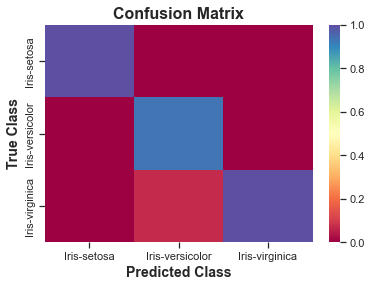

In [70]:
import seaborn as sns 
import matplotlib.pyplot as plt
cm = metrics.confusion_matrix(pred_data['class'].values, pred_data['pred_class'].values, labels=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
cm = cm/sum(cm)
cmap = sns.color_palette("Spectral", as_cmap=True)
f, ax = plt.subplots()
sns.heatmap(cm, annot=False, ax=ax, fmt='.4f', cmap=cmap)
ticklabels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
ax.set(xticklabels=ticklabels, yticklabels=ticklabels)
ax.set_title('Confusion Matrix', fontsize=16, fontweight='bold')
ax.set_xlabel('Predicted Class', fontsize=14, fontweight='bold')
ax.set_ylabel('True Class', fontsize=14, fontweight='bold')
plt.savefig('Confusion_Matrix.pdf', format='pdf', bbox_inches='tight', transparent=True, dpi=300)